## Matis Braun

# **Variational Autoencoder (VAE) with Latent Space Interpolation on MNIST**

## Project Description

We explore the concepts of **Variational Autoencoders (VAEs)** by implementing and training a convolutional VAE on the MNIST dataset. The objectives are to see how VAEs encode data into a structured latent space and to investigate how this latent space can be leveraged for generating new data and understanding data features.

## Step 1: Loading the MNIST Dataset

In this first step, we load the MNIST dataset, which contains 28x28 grayscale images of handwritten digits (0-9). Each image represents a single digit.


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Loading MNIST data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.24MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 156kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.43MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.50MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Step 2: Defining the Convolutional VAE Model

In this section, we define the architecture of a **Variational Autoencoder (VAE)** with convolutional layers, designed to process the MNIST dataset.

This architecture allows the VAE to encode images to a low-dimensional latent space and then decode them back to their original shape.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(ConvVAE, self).__init__()

        # Encoder with convolutional layers
        self.encoder = nn.Sequential(
            # Input 1x28x28 -> Output 32x14x14
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            # Input 32x14x14 -> Output 64x7x7
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            # Input 64x7x7 -> Output 128x1x1
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Layers to produce mean and variance vectors
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)


        # Mean vector of the latent space

        # Log-variance vector of the latent space

        # Decoder starting with a fully connected layer
        # Transform latent vector back to decoder shape
        self.fc_decoder = nn.Linear(latent_dim, 128)

        # Decoder with transposed convolutional layers to reconstruct the image
        # Input 128x1x1 -> Output 64x7x7

        # Input 64x7x7 -> Output 32x14x14

        # Input 32x14x14 -> Output 1x28x28

        # Normalize output pixels between 0 and 1

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 1, 1)),
            nn.ConvTranspose2d(128, 64, 7, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )


    def encode(self, x):
        #for layer in self.encoder:
        #    x = layer(x)
        #    print("Encoder layer output shape:", x.shape)
        # Apply the encoder to extract features and flatten the result
        x = self.encoder(x)
        # Compute mean and log-variance for the latent space distribution
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        #print("Mu shape:", mu.shape)
        #print("Logvar shape:", logvar.shape)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Compute standard deviation from log-variance
        std = torch.exp(0.5 * logvar)
        # Sample epsilon from a normal distribution
        eps = torch.randn_like(logvar)
        # Reparameterization trick to sample z from N(mu, sigma^2)
        return mu + eps * std

    def decode(self, z):
        # Apply fully connected layer to expand latent vector to decoder's initial shape
        h = self.fc_decoder(z)
        #print("Decoder FC output shape:", h.shape)
        # Apply the decoder to reconstruct the image
        #for layer in self.decoder:
        #    h = layer(h)
        #    print("Decoder layer output shape:", h.shape)
        return self.decoder(h)

    def forward(self, x):
        # Forward pass through encoder
        mu, logvar = self.encode(x)
        # Sample from latent distribution
        z = self.reparameterize(mu, logvar)
        # Forward pass through decoder
        return self.decode(z), mu, logvar

## Step 3: Defining the VAE Loss Function

The Variational Autoencoder (VAE) loss function combines two key components: **Reconstruction Loss** and **KL-Divergence Loss**. Together, these terms encourage the VAE to produce high-quality reconstructions while also regularizing the latent space.

By using this combined loss, the VAE learns to generate images that resemble the input data and maintain a well-structured latent space that facilitates tasks like image generation and interpolation.

In [ ]:

def loss_function(recon_x, x, mu, logvar):
    batch_size = recon_x.size(0)
    # Flatten the output to match the shape of x
    recon_x = recon_x.view(batch_size, -1)
    # Also flatten x for consistency
    x = x.view(batch_size, -1)
    # Reconstruction loss: Binary Cross Entropy
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL-Divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    # Total VAE loss
    return BCE + KLD

## Step 4: Training the VAE Model

In this step, we set up and execute the training loop for the Variational Autoencoder (VAE) model. The training process optimizes the model’s parameters to minimize the combined loss function over multiple epochs.


The training loop fine-tunes the VAE’s parameters to generate accurate reconstructions and a well-structured latent space, which can be visualized or used for generative tasks after training.

In [ ]:
from torch.optim import Adam


# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizer, and send model to device
latent_dim = 2
model = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move data to device
        data = data.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through the VAE
        recon_x, mu, logvar = model(data)

        # Calculate the VAE loss
        loss = loss_function(recon_x, data, mu, logvar)

        # Backpropagation and optimization
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    # Print the average loss for each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 1/10, Loss: 199.9933
Epoch 2/10, Loss: 166.6983
Epoch 3/10, Loss: 163.9200
Epoch 4/10, Loss: 161.8211
Epoch 5/10, Loss: 159.7793
Epoch 6/10, Loss: 158.1532
Epoch 7/10, Loss: 156.7414
Epoch 8/10, Loss: 155.7770
Epoch 9/10, Loss: 154.8771
Epoch 10/10, Loss: 154.2598


## Step 5: Interpolation in the Latent Space

In this final step, we perform **latent space interpolation** to explore the continuity of the VAE's learned latent space. By interpolating between two points in the latent space (representing different digits), we can generate a smooth transition between them.

### Visualization Explanation:

The visualization showcases the VAE’s ability to generate new images by sampling from the latent space. The smooth transition between digits demonstrates that the VAE has learned a well-structured, continuous latent space where similar concepts (like digits) are located close to each other. This capability can be useful for generating synthetic data or exploring variations in features.

By interpolating in this manner, we can observe how the VAE understands and generates the fundamental features of the digits in the MNIST dataset.

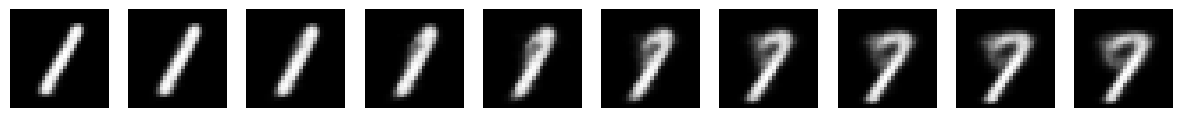

In [ ]:

import matplotlib.pyplot as plt


# Define the interpolation function
def interpolate_and_generate(model, z_start, z_end, steps=10):
    # Create interpolation steps between two latent vectors
    images = []
    # Decode each interpolated point and store the images
    for t in torch.linspace(0, 1, steps):
        z = (1 - t) * z_start + t * z_end
        img = model.decode(z).cpu().detach().numpy()
        images.append(img.reshape(28, 28))
    return images

# Select two random digits to interpolate between
model.eval()
with torch.no_grad():
    # Pass the data directly without reshaping, as the model expects [1, 1, 28, 28]
    #z_start = torch.randn(1, latent_dim, device=device)
    #z_end = torch.randn(1, latent_dim, device=device)
    digit_1 = next(data for data, label in train_dataset if label == 1)
    digit_7 = next(data for data, label in train_dataset if label == 7)
    data1 = digit_1.unsqueeze(0).to(device)
    data2 = digit_7.unsqueeze(0).to(device)
    z_start, _ = model.encode(data1)
    z_end, _ = model.encode(data2)
    images = interpolate_and_generate(model, z_start, z_end, steps=10)

# Plot interpolated images
fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
for i, img in enumerate(images):
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
plt.show()

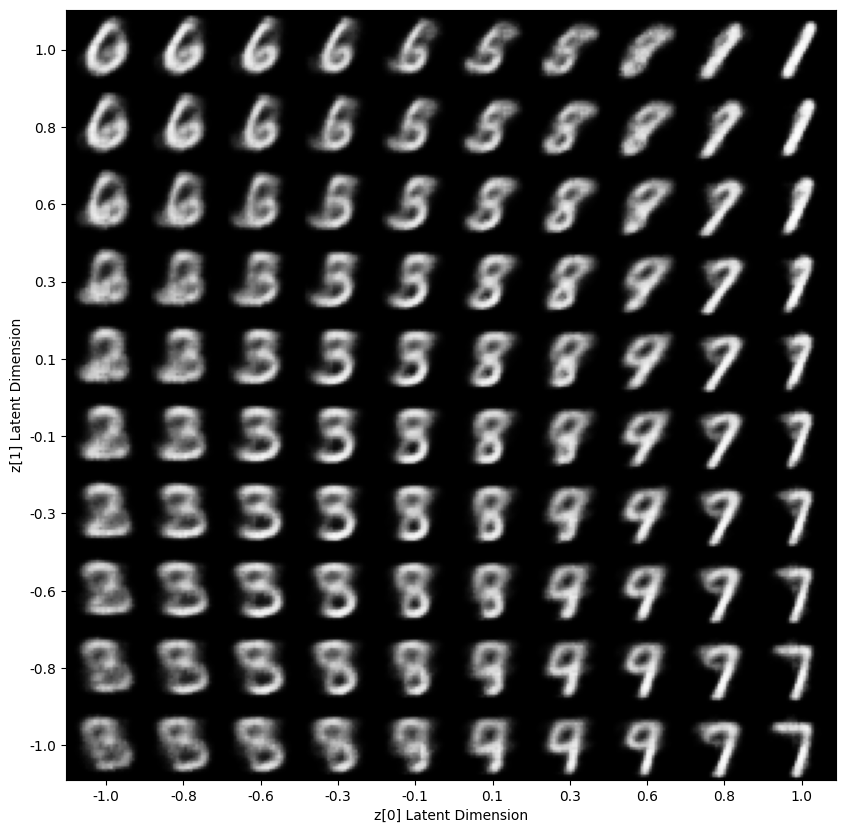

In [ ]:
import numpy as np

digit_size = 28
figure = np.zeros((digit_size * 10, digit_size * 10))

# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-1, 1, 10)
grid_y = np.linspace(-1, 1, 10)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
        x_decoded = model.decode(z_sample).cpu().detach().numpy()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = 10 * digit_size + start_range + 1
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
pixel_range = np.linspace(start_range, end_range - digit_size, len(sample_range_x))

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0] Latent Dimension")
plt.ylabel("z[1] Latent Dimension")
plt.imshow(figure, cmap='Greys_r')
plt.show()


In [ ]:
digit = [data for data, label in train_dataset]
label = [label for data, label in train_dataset]
#digit = digit[:10000]
#label = label[:10000]
z = []
for i in range(len(digit)):
    data = digit[i].unsqueeze(0).to(device)
    tmp = model.encode(data)
    z.append(tmp)

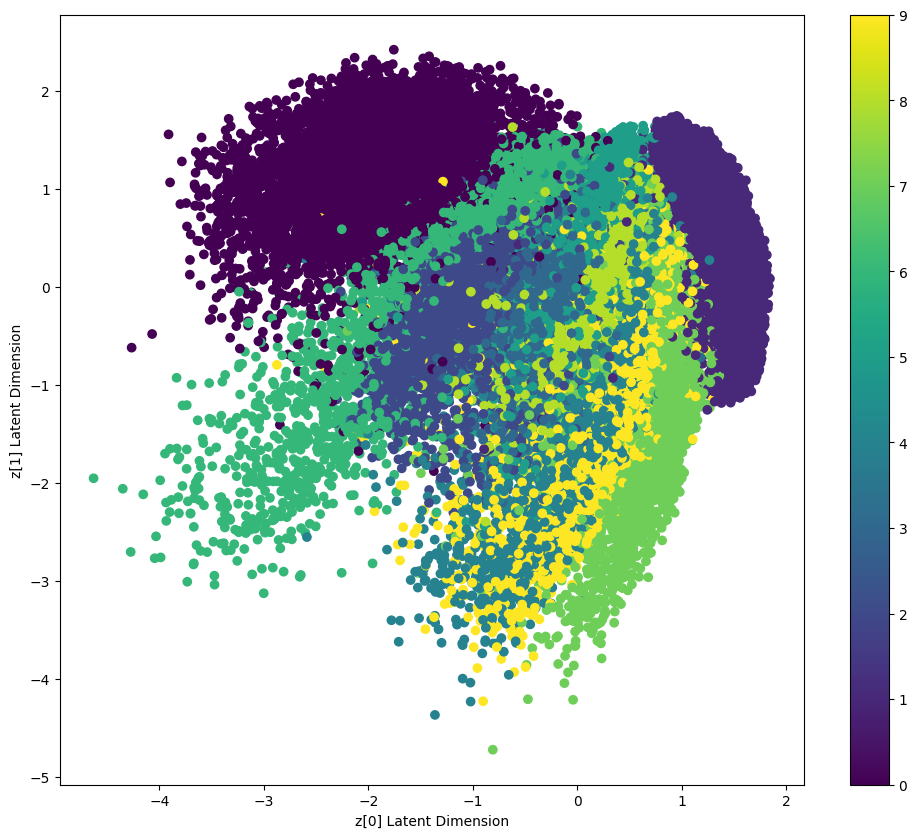

In [ ]:
resx = [tensor[0][0][0].cpu().detach().numpy() for tensor in z]
resy = [tensor[0][0][1].cpu().detach().numpy() for tensor in z]

plt.figure(figsize=(12, 10))
plt.scatter(resx, resy, c=label)
plt.colorbar()
plt.xlabel("z[0] Latent Dimension")
plt.ylabel("z[1] Latent Dimension")
plt.show()

## Un plus grand modèle

Maintenant, nous allons tester avec un plus grand modèle. Pour l'encoder, on va avoir en taille finale (256, 1, 1) (contre (128, 1, 1) pour le modèle d'avant). On aura plus de précision pour la transformation dans l'espace latent

In [ ]:
class ConvVAE2(nn.Module):
    def __init__(self, latent_dim=2):
        super(ConvVAE2, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 7),
            nn.ReLU(),
            nn.Flatten(),
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.fc_decoder = nn.Linear(latent_dim, 256)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 1, 1)),
            nn.ConvTranspose2d(256, 128, 7, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decoder(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
from torch.optim import Adam


# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizer, and send model to device
latent_dim = 2
model2 = ConvVAE2(latent_dim=latent_dim).to(device)
optimizer = Adam(model2.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model2.train()  # Set model to training mode
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move data to device
        data = data.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through the VAE
        recon_x, mu, logvar = model2(data)

        # Calculate the VAE loss
        loss = loss_function(recon_x, data, mu, logvar)

        # Backpropagation and optimization
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    # Print the average loss for each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 1/10, Loss: 183.3357
Epoch 2/10, Loss: 160.9536
Epoch 3/10, Loss: 156.9773
Epoch 4/10, Loss: 154.3794
Epoch 5/10, Loss: 152.5413
Epoch 6/10, Loss: 151.2818
Epoch 7/10, Loss: 150.4002
Epoch 8/10, Loss: 149.6359
Epoch 9/10, Loss: 149.0680
Epoch 10/10, Loss: 148.4544


On constate une très légère amélioration des résultats de la loss, mais pour environ une exécution du code 10 fois plus long, ce n'est pas du tout intéressant.

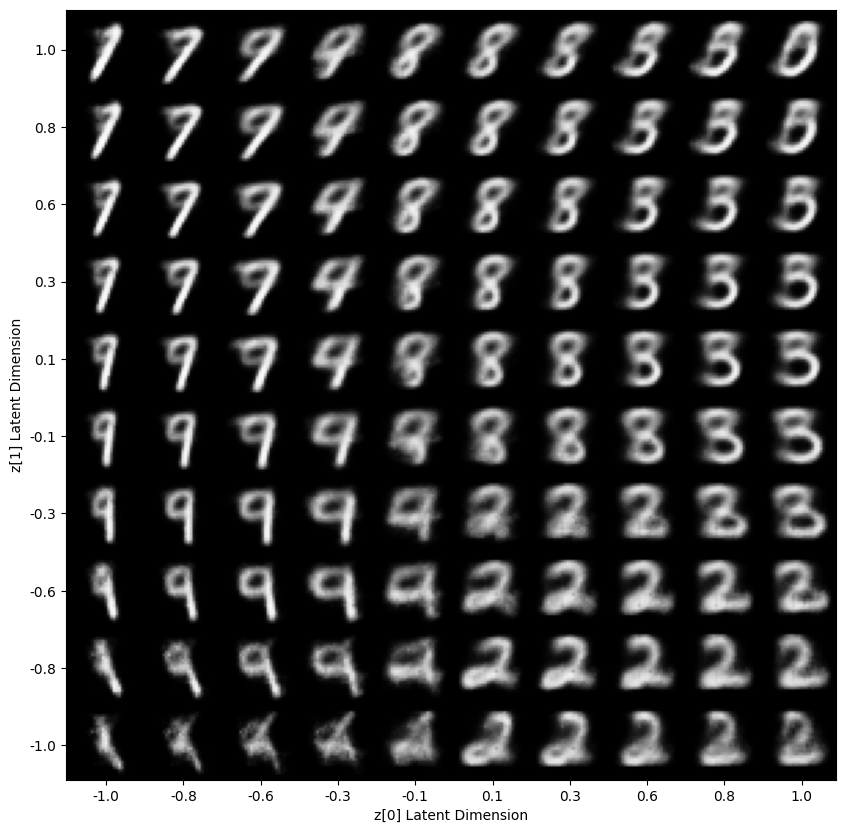

In [ ]:
import numpy as np

digit_size = 28
figure = np.zeros((digit_size * 10, digit_size * 10))

# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-1, 1, 10)
grid_y = np.linspace(-1, 1, 10)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
        x_decoded = model2.decode(z_sample).cpu().detach().numpy()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = 10 * digit_size + start_range + 1
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
pixel_range = np.linspace(start_range, end_range - digit_size, len(sample_range_x))

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0] Latent Dimension")
plt.ylabel("z[1] Latent Dimension")
plt.imshow(figure, cmap='Greys_r')
plt.show()


Cela à l'air d'être un petit peu mieux

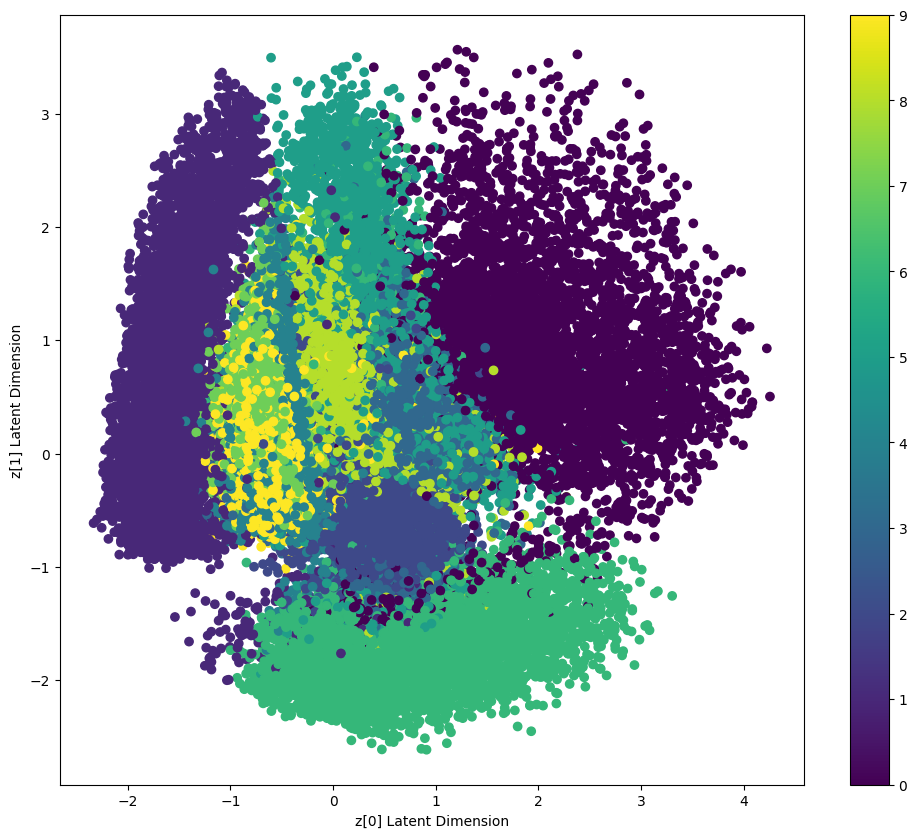

In [ ]:
digit = [data for data, label in train_dataset]
label = [label for data, label in train_dataset]
#digit = digit[:10000]
#label = label[:10000]
z = []
for i in range(len(digit)):
    data = digit[i].unsqueeze(0).to(device)
    tmp = model2.encode(data)
    z.append(tmp)
resx = [tensor[0][0][0].cpu().detach().numpy() for tensor in z]
resy = [tensor[0][0][1].cpu().detach().numpy() for tensor in z]

plt.figure(figsize=(12, 10))
plt.scatter(resx, resy, c=label)
plt.colorbar()
plt.xlabel("z[0] Latent Dimension")
plt.ylabel("z[1] Latent Dimension")
plt.show()

On constate tout de même une légère amélioration de la dissociation des clusters par rapport à avant. On constate une séparation entre le 9, 8, 7 et 4, alors qu'avant, le 4 etait assez mélangé.

## Un plus petit modèle

Maintenant, nous allons tester avec un plus petit modèle que celui de base. Pour le decoder, on va avoir en taille finale (32, 7, 7) (contre (128, 1, 1)). Normalement, on devrait avoir de moins bons résultats

In [ ]:
class ConvVAE3(nn.Module):
    def __init__(self, latent_dim=2):
        super(ConvVAE3, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        self.fc_mu = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(32 * 7 * 7, latent_dim)

        self.fc_decoder = nn.Linear(latent_dim, 32 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decoder(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 2
model3 = ConvVAE3(latent_dim=latent_dim).to(device)
optimizer2 = Adam(model3.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model3.train()  # Set model to training mode
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move data to device
        data = data.to(device)

        # Zero the gradients
        optimizer2.zero_grad()

        # Forward pass through the VAE
        recon_x, mu, logvar = model3(data)

        # Calculate the VAE loss
        loss = loss_function(recon_x, data, mu, logvar)

        # Backpropagation and optimization
        loss.backward()

        train_loss += loss.item()
        optimizer2.step()

    # Print the average loss for each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 1/10, Loss: 226.2509
Epoch 2/10, Loss: 182.0849
Epoch 3/10, Loss: 177.4590
Epoch 4/10, Loss: 174.6335
Epoch 5/10, Loss: 172.4667
Epoch 6/10, Loss: 170.5531
Epoch 7/10, Loss: 168.9984
Epoch 8/10, Loss: 167.6528
Epoch 9/10, Loss: 166.4159
Epoch 10/10, Loss: 165.3723


On constate que la loss est moins basse que le modèle de base

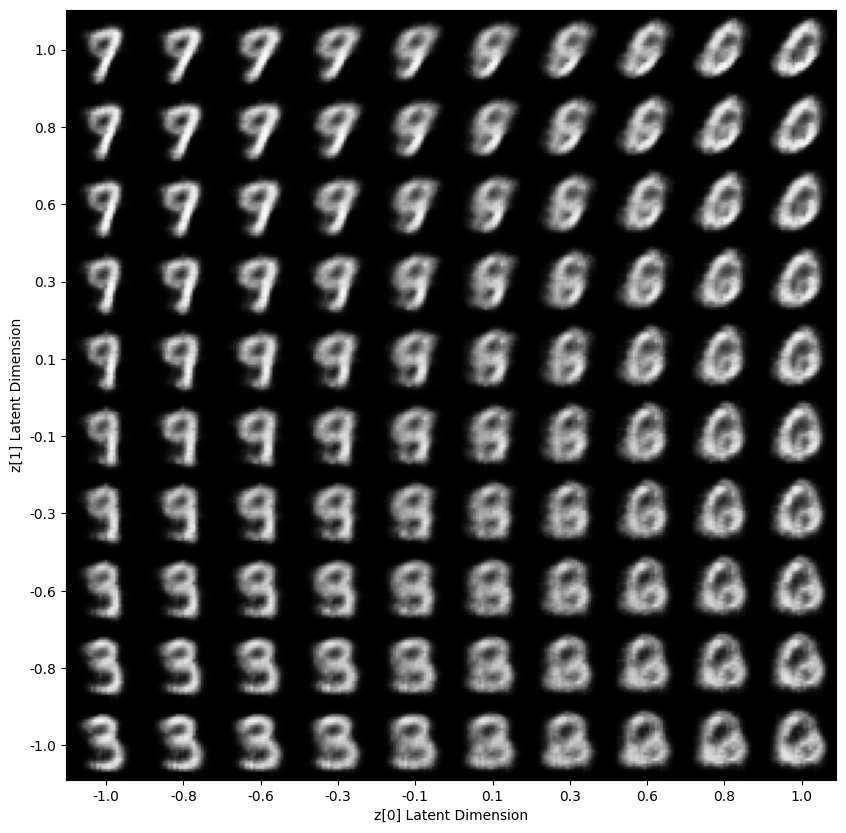

In [ ]:
import numpy as np

digit_size = 28
figure = np.zeros((digit_size * 10, digit_size * 10))

# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-1, 1, 10)
grid_y = np.linspace(-1, 1, 10)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
        x_decoded = model3.decode(z_sample).cpu().detach().numpy()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = 10 * digit_size + start_range + 1
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
pixel_range = np.linspace(start_range, end_range - digit_size, len(sample_range_x))

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0] Latent Dimension")
plt.ylabel("z[1] Latent Dimension")
plt.imshow(figure, cmap='Greys_r')
plt.show()


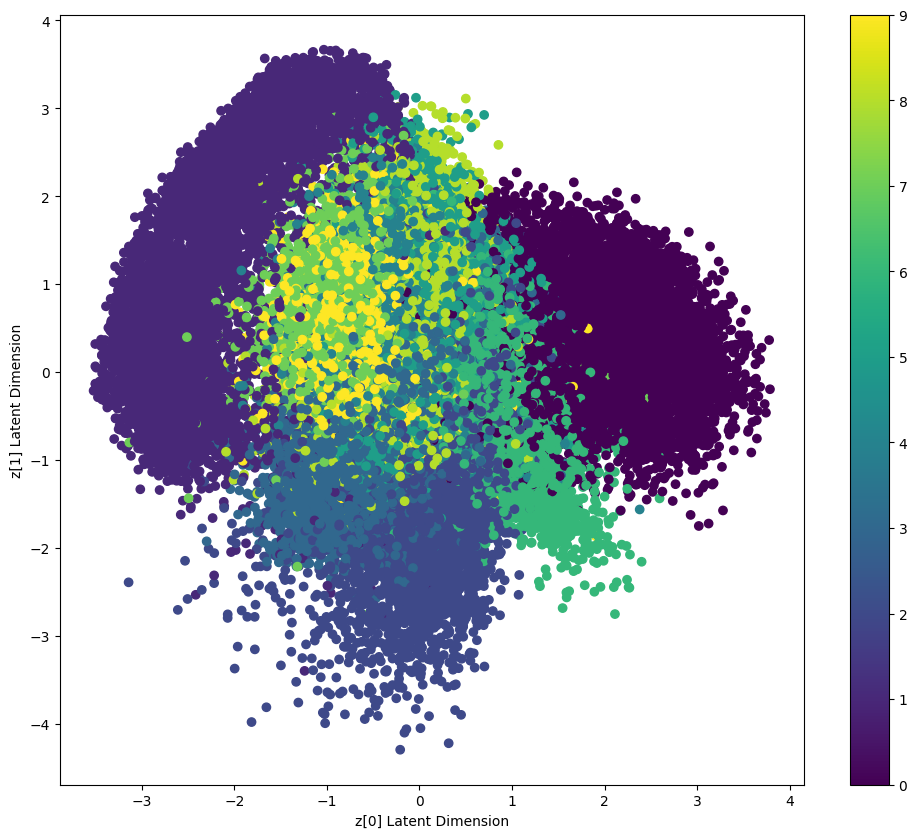

In [ ]:
digit = [data for data, label in train_dataset]
label = [label for data, label in train_dataset]
#digit = digit[:10000]
#label = label[:10000]
z = []
for i in range(len(digit)):
    data = digit[i].unsqueeze(0).to(device)
    tmp = model3.encode(data)
    z.append(tmp)
resx = [tensor[0][0][0].cpu().detach().numpy() for tensor in z]
resy = [tensor[0][0][1].cpu().detach().numpy() for tensor in z]

plt.figure(figsize=(12, 10))
plt.scatter(resx, resy, c=label)
plt.colorbar()
plt.xlabel("z[0] Latent Dimension")
plt.ylabel("z[1] Latent Dimension")
plt.show()

Ici, on voit vraiment que les clusters des valeurs 9, 8, 7 et 4 sont complètement mélanger, on va pas vraiment pouvoir bien les représenter, et on le voit bien au dessus dans le decodage dans l'espace latent

## MLE

Maintenant, on va faire un MLE, qui est l'une (si ce n'est) la meilleur methode pour un VAE

In [ ]:
class MLPVAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(MLPVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(200, latent_dim)
        self.fc_logvar = nn.Linear(200, latent_dim)

        self.fc_decoder = nn.Linear(latent_dim, 200)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decoder(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 2
model4 = MLPVAE(latent_dim=latent_dim).to(device)
optimizer3 = Adam(model4.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model4.train()  # Set model to training mode
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move data to device
        data = data.to(device)

        # Zero the gradients
        optimizer3.zero_grad()

        # Forward pass through the VAE
        recon_x, mu, logvar = model4(data)

        # Calculate the VAE loss
        loss = loss_function(recon_x, data, mu, logvar)

        # Backpropagation and optimization
        loss.backward()

        train_loss += loss.item()
        optimizer3.step()

    # Print the average loss for each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 1/10, Loss: 186.9244
Epoch 2/10, Loss: 161.5326
Epoch 3/10, Loss: 155.8868
Epoch 4/10, Loss: 152.5396
Epoch 5/10, Loss: 150.1494
Epoch 6/10, Loss: 148.3287
Epoch 7/10, Loss: 146.9304
Epoch 8/10, Loss: 145.8567
Epoch 9/10, Loss: 144.9196
Epoch 10/10, Loss: 144.1846


Ici, on constate qu'avec un MLE basique, on a de meilleurs résultats que le modèle normal et optimisé.

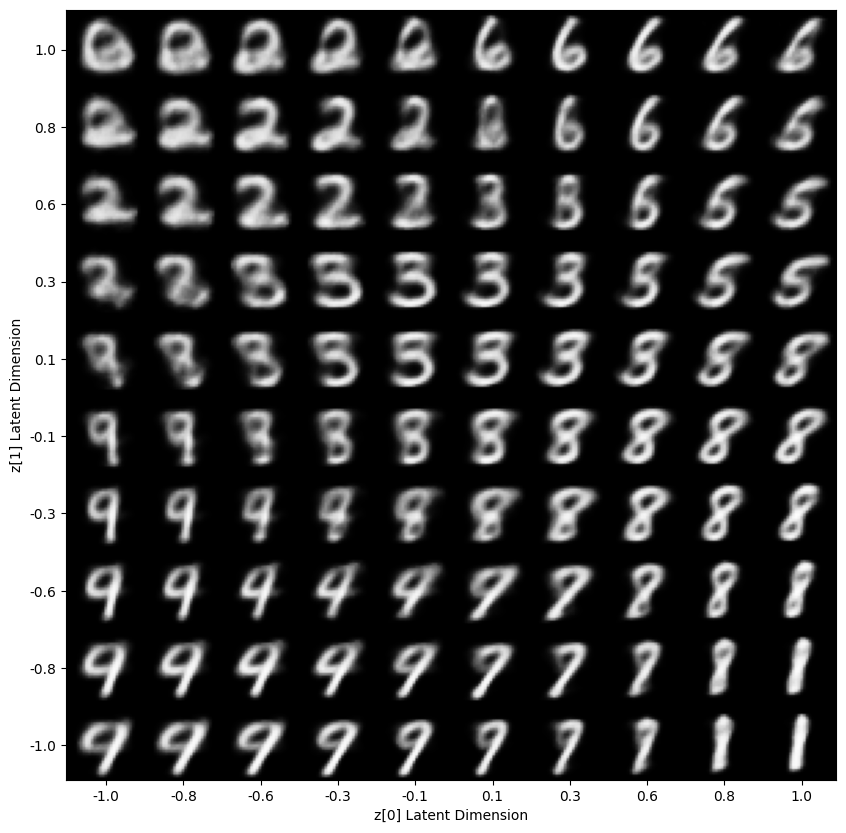

In [ ]:
import numpy as np

digit_size = 28
figure = np.zeros((digit_size * 10, digit_size * 10))

# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-1, 1, 10)
grid_y = np.linspace(-1, 1, 10)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
        x_decoded = model4.decode(z_sample).cpu().detach().numpy()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = 10 * digit_size + start_range + 1
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
pixel_range = np.linspace(start_range, end_range - digit_size, len(sample_range_x))

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0] Latent Dimension")
plt.ylabel("z[1] Latent Dimension")
plt.imshow(figure, cmap='Greys_r')
plt.show()


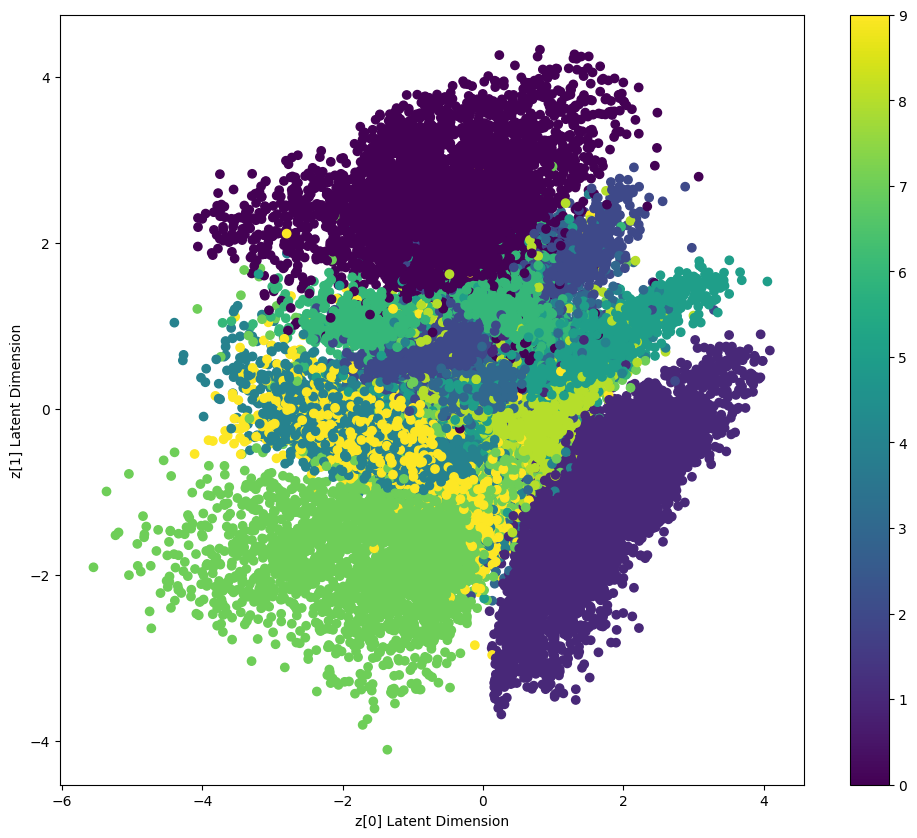

In [ ]:
digit = [data for data, label in train_dataset]
label = [label for data, label in train_dataset]
#digit = digit[:10000]
#label = label[:10000]
z = []
for i in range(len(digit)):
    data = digit[i].unsqueeze(0).to(device)
    tmp = model4.encode(data)
    z.append(tmp)
resx = [tensor[0][0][0].cpu().detach().numpy() for tensor in z]
resy = [tensor[0][0][1].cpu().detach().numpy() for tensor in z]

plt.figure(figsize=(12, 10))
plt.scatter(resx, resy, c=label)
plt.colorbar()
plt.xlabel("z[0] Latent Dimension")
plt.ylabel("z[1] Latent Dimension")
plt.show()

On a de meilleurs résultats même si le cluster du 9 et 4 sont bien mélanger (et cela ce voit dans l'autre schémas)

## Tester l'impact de KLD sur la régularisation de l'espace latent

Dans la loss fonction, on va modifier le poids de KLD pour voir son impact. Ici, on va le multiplié par 0.2. On va aussi utilisé le modèle MLE pour avoir de meilleur résultats.

In [ ]:
def loss_function2(recon_x, x, mu, logvar):
    batch_size = recon_x.size(0)
    recon_x = recon_x.view(batch_size, -1)
    x = x.view(batch_size, -1)

    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + 0.2 * KLD

In [ ]:
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 2
model4 = MLPVAE(latent_dim=latent_dim).to(device)
optimizer3 = Adam(model4.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model4.train()  # Set model to training mode
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move data to device
        data = data.to(device)

        # Zero the gradients
        optimizer3.zero_grad()

        # Forward pass through the VAE
        recon_x, mu, logvar = model4(data)

        # Calculate the VAE loss
        loss = loss_function2(recon_x, data, mu, logvar)

        # Backpropagation and optimization
        loss.backward()

        train_loss += loss.item()
        optimizer3.step()

    # Print the average loss for each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 1/10, Loss: 181.5936
Epoch 2/10, Loss: 155.5531
Epoch 3/10, Loss: 150.0187
Epoch 4/10, Loss: 146.6893
Epoch 5/10, Loss: 144.4404
Epoch 6/10, Loss: 143.0863
Epoch 7/10, Loss: 141.6727
Epoch 8/10, Loss: 140.6872
Epoch 9/10, Loss: 139.8249
Epoch 10/10, Loss: 138.9222


On constate que cela impact nos résultats. KLD mesure la différence entre 2 distributions de probabilités. Ici, mettre un poids moins grand fait que le modèle va un peu plus "expérmimenter", ce qui peu être positif comme on peut le voir.

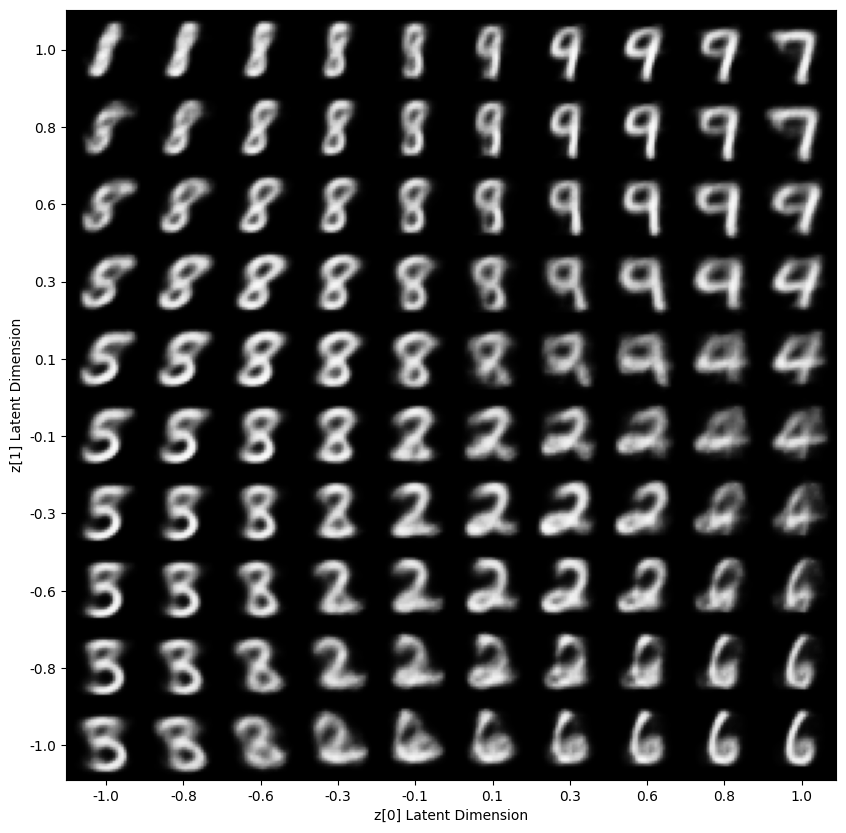

In [ ]:
import numpy as np

digit_size = 28
figure = np.zeros((digit_size * 10, digit_size * 10))

# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-1, 1, 10)
grid_y = np.linspace(-1, 1, 10)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
        x_decoded = model4.decode(z_sample).cpu().detach().numpy()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = 10 * digit_size + start_range + 1
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
pixel_range = np.linspace(start_range, end_range - digit_size, len(sample_range_x))

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0] Latent Dimension")
plt.ylabel("z[1] Latent Dimension")
plt.imshow(figure, cmap='Greys_r')
plt.show()


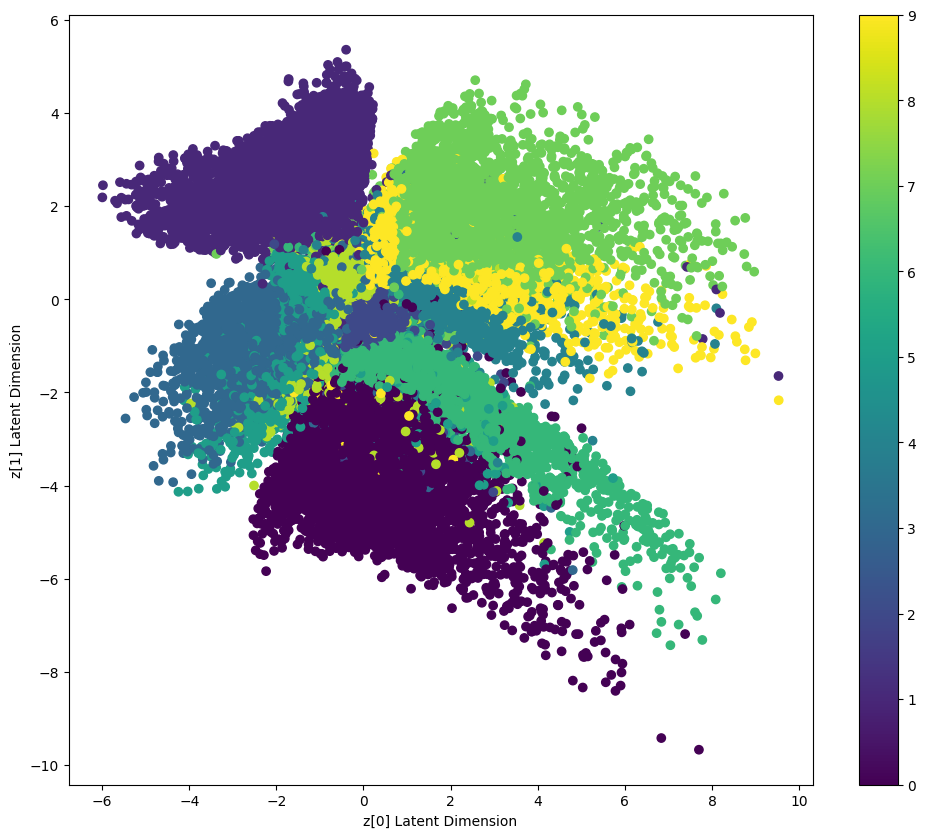

In [ ]:
digit = [data for data, label in train_dataset]
label = [label for data, label in train_dataset]
#digit = digit[:10000]
#label = label[:10000]
z = []
for i in range(len(digit)):
    data = digit[i].unsqueeze(0).to(device)
    tmp = model4.encode(data)
    z.append(tmp)
resx = [tensor[0][0][0].cpu().detach().numpy() for tensor in z]
resy = [tensor[0][0][1].cpu().detach().numpy() for tensor in z]

plt.figure(figsize=(12, 10))
plt.scatter(resx, resy, c=label)
plt.colorbar()
plt.xlabel("z[0] Latent Dimension")
plt.ylabel("z[1] Latent Dimension")
plt.show()

Ici, on constate que les clusters ont bien réussi à ne pas trop se mélanger, ce qui est très bien, maintenant, il faudrait qu'ils soient mieux distribué dans l'espace latent et pas regroupé vers (0,0)

Ici, notre KLD va avoir un poids de 5, donc va être plus important.

In [ ]:
def loss_function3(recon_x, x, mu, logvar):
    batch_size = recon_x.size(0)
    recon_x = recon_x.view(batch_size, -1)
    x = x.view(batch_size, -1)

    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + 5 * KLD

In [ ]:
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 2
model4 = MLPVAE(latent_dim=latent_dim).to(device)
optimizer3 = Adam(model4.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model4.train()  # Set model to training mode
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move data to device
        data = data.to(device)

        # Zero the gradients
        optimizer3.zero_grad()

        # Forward pass through the VAE
        recon_x, mu, logvar = model4(data)

        # Calculate the VAE loss
        loss = loss_function3(recon_x, data, mu, logvar)

        # Backpropagation and optimization
        loss.backward()

        train_loss += loss.item()
        optimizer3.step()

    # Print the average loss for each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 1/10, Loss: 197.5513
Epoch 2/10, Loss: 178.1031
Epoch 3/10, Loss: 174.1228
Epoch 4/10, Loss: 171.8112
Epoch 5/10, Loss: 170.0844
Epoch 6/10, Loss: 168.8536
Epoch 7/10, Loss: 167.8939
Epoch 8/10, Loss: 167.0950
Epoch 9/10, Loss: 166.4617
Epoch 10/10, Loss: 165.8411


Ici, on constate que notre loss n'est pas très bonne. Donner à notre KLD un plus gros poids n'aide pas dans les résultats. Il vaut donc mieux laisser notre modèle "expérimenter" et non pas "copier" la distribution normale.

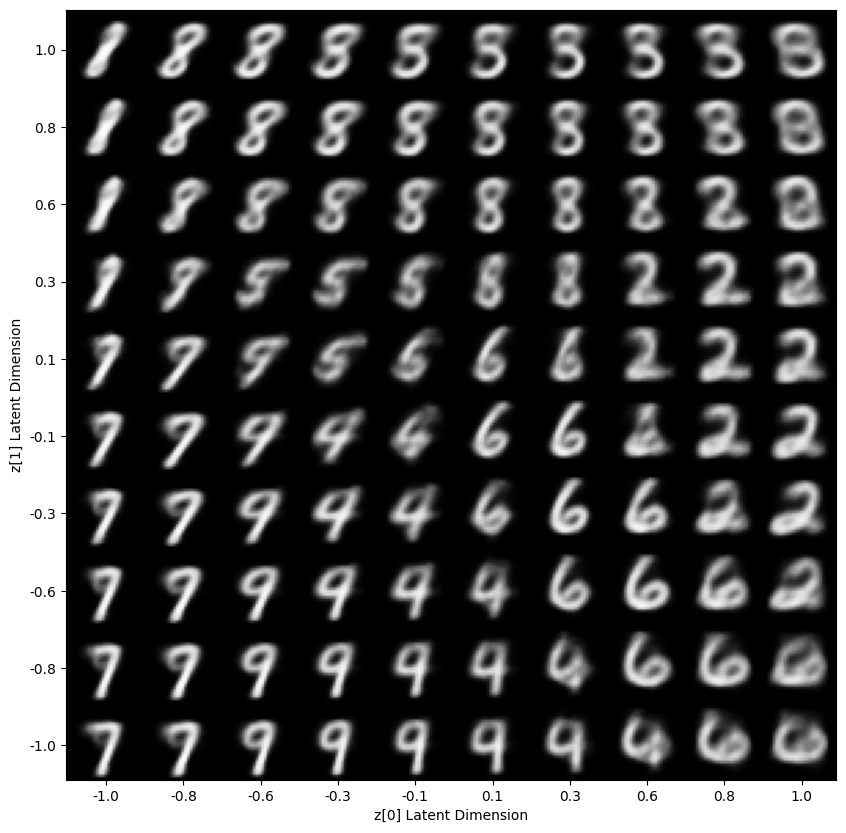

In [ ]:
import numpy as np

digit_size = 28
figure = np.zeros((digit_size * 10, digit_size * 10))

# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-1, 1, 10)
grid_y = np.linspace(-1, 1, 10)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
        x_decoded = model4.decode(z_sample).cpu().detach().numpy()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = 10 * digit_size + start_range + 1
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
pixel_range = np.linspace(start_range, end_range - digit_size, len(sample_range_x))

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0] Latent Dimension")
plt.ylabel("z[1] Latent Dimension")
plt.imshow(figure, cmap='Greys_r')
plt.show()


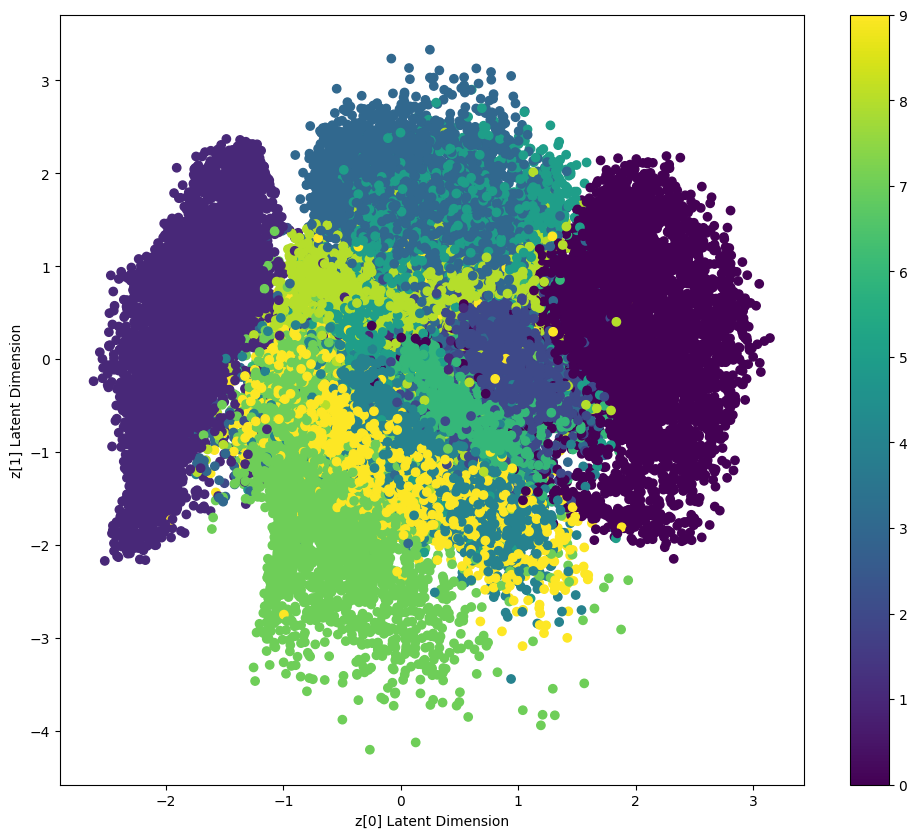

In [ ]:
digit = [data for data, label in train_dataset]
label = [label for data, label in train_dataset]
#digit = digit[:10000]
#label = label[:10000]
z = []
for i in range(len(digit)):
    data = digit[i].unsqueeze(0).to(device)
    tmp = model4.encode(data)
    z.append(tmp)
resx = [tensor[0][0][0].cpu().detach().numpy() for tensor in z]
resy = [tensor[0][0][1].cpu().detach().numpy() for tensor in z]

plt.figure(figsize=(12, 10))
plt.scatter(resx, resy, c=label)
plt.colorbar()
plt.xlabel("z[0] Latent Dimension")
plt.ylabel("z[1] Latent Dimension")
plt.show()

On constate donc que la plupart des clusters hors 0, 1 et 7 sont mélangés

POur conclure, les meilleurs résultats sont, durant ce TP, lorsuqe l'on utilise le modèle de VAE avec MLE, et lorsque l'on donne moins d'importance au KLD dans la loss fonction